In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.fft import fft, fftfreq
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import DeterministicProcess
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'
sns.set_palette("husl")

# Time Series data with single variable

## Simulated data generation

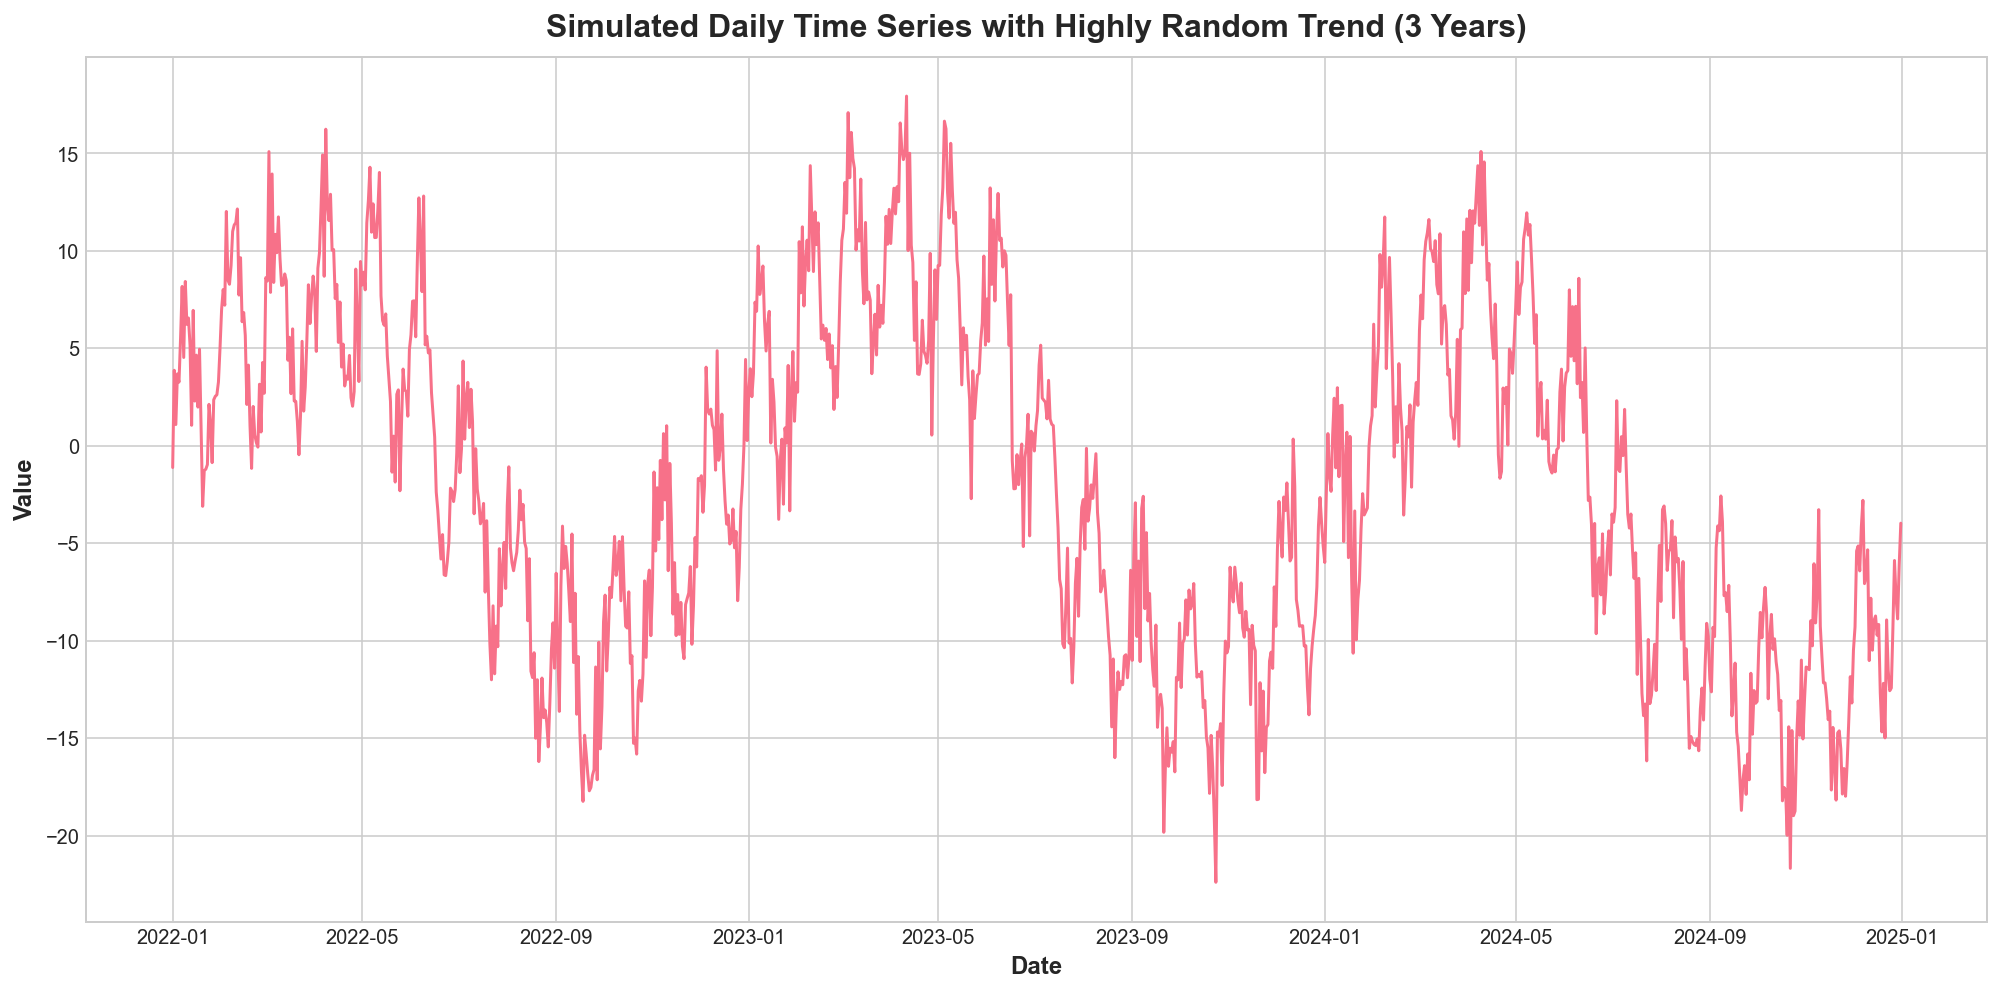

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# create the date range for the simulated data
dates = pd.date_range(start='2022-01-01', end='2024-12-31', freq='D')

# Random walk without drift
# higher loc may result in increasing trend
trend_steps = np.random.normal(loc=[0], scale=0.2, size=len(dates))
trend = np.cumsum(trend_steps)

# based on the sin method to create a smooth trend for the seasonality
yearly_seasonality = 10 * np.sin(2 * np.pi * dates.dayofyear / 365)
monthly_seasonality = 5 * np.sin(2 * np.pi * dates.day / 30)

# create the noise with antoher scale 
noise = np.random.normal(loc=0, scale=2, size=len(dates))

# add up the trend, seasonality and noise for the data
data = trend + yearly_seasonality + monthly_seasonality + noise

# convert it into a dataframe with the date and values columns
time_series = pd.DataFrame(data, index=dates)
time_series = time_series.reset_index()
time_series.columns = ['date', 'values']

# simplementation time series chart to display the data generated
plt.figure(figsize=(14, 7))
plt.plot(time_series.set_index('date')['values'])
plt.title('Simulated Daily Time Series with Highly Random Trend (3 Years)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()

## Time Series Analyzer

In [3]:
class TimeSeriesAnalyzer:
    def __init__(self, data, date_column=None, value_column=None):
        """
        Initialize the time series analyzer

        Parameters:
        - data: DataFrame with date and value columns, or Series with datetime index
        - date_column: name of date column (if DataFrame)
        - value_column: name of value column (if DataFrame)
        """
        # assign the target column value into the class instance
        if date_column:
            self.date_column = date_column
        if value_column:
            self.value_column = value_column

        # turn the data frame into a time series for futher analysis
        if isinstance(data, pd.DataFrame):
            self.df = data.copy()
            if date_column:
                self.df[date_column] = pd.to_datetime(self.df[date_column])
                self.df = self.df.sort_values(
                    date_column).reset_index(drop=True)
                self.df.set_index(date_column, inplace=True)
            self.ts = self.df[value_column] if value_column else self.df.iloc[:, 0]
        else:
            self.ts = data.copy()
            self.df = pd.DataFrame({'value': data})

        # Ensure datetime index
        if not isinstance(self.ts.index, pd.DatetimeIndex):
            raise ValueError("Index must be datetime")

        # Spread to weekly and yearly data
        self.daily, self.weekly, self.monthly, self.yearly = self.daily_to_weekly_and_yearly(
            date_col=date_column, value_col=value_column, method='sum', week_start='Sunday')

        # count the time step and lag_1 for the time series data for futher analysis
        self.df['time'] = np.arange(len(self.df.index))
        self.df['lag_1'] = self.df[value_column].shift(1)

    def basic_statistics(self):
        """Calculate basic statistics"""
        print("=== BASIC STATISTICS ===")
        print(f"Period: {self.ts.index.min()} to {self.ts.index.max()}")
        print(f"Total observations: {len(self.ts)}")
        print(f"Mean: {self.ts.mean():.4f}")
        print(f"Std: {self.ts.std():.4f}")
        print(f"Min: {self.ts.min():.4f}")
        print(f"Max: {self.ts.max():.4f}")
        print(f"Missing values: {self.ts.isna().sum()}")

    def visual_inspection(self):
        """Create visualizations for pattern detection"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Time series plot
        axes[0, 0].plot(self.monthly.index, self.monthly.values)
        axes[0, 0].set_title('Time Series')
        axes[0, 0].set_xlabel('Date')
        axes[0, 0].set_ylabel(f'{self.value_column}')

        # Monthly boxplot
        axes[0, 1].boxplot(x=self.monthly.values)
        axes[0, 1].set_title('Monthly Seasonality')
        axes[0, 1].set_ylabel(f'{self.value_column}')

        # Day of week boxplot
        axes[1, 0].boxplot(self.weekly.values)
        axes[1, 0].set_title('Day of Week Seasonality')
        axes[1, 0].set_xlabel('Day of Week')
        axes[1, 0].set_ylabel(f'{self.value_column}')

        # Histogram
        axes[1, 1].hist(self.ts.values, bins=30, alpha=0.7)
        axes[1, 1].set_title('Distribution')
        axes[1, 1].set_xlabel(f'{self.value_column}')
        axes[1, 1].set_ylabel('Frequency')

        plt.tight_layout()
        plt.show()

    def time_step_lag_linear_regression_plot(self):
        fig, axes = plt.subplots(2, 1, figsize=(15, 10))
        axes[0].plot(self.df['time'], self.df[self.value_column], color='0.75')
        sns.regplot(x='time', y=self.value_column, data=self.df,
                    ci=None, scatter_kws=dict(color='0.25'), ax=axes[0])
        axes[0].set_title(f'Time Plot of {self.value_column}')

        sns.regplot(x='lag_1', y=self.value_column, data=self.df,
                    ci=None, scatter_kws=dict(color='0.25'), ax=axes[1])
        axes[1].set_aspect('equal')
        axes[1].set_title(f'Lag Plot (Shift = 1) of {self.value_column}')

    def time_step_linear_regression_fit(self):
        X = self.df.loc[:, ['time']]
        y = self.df.loc[:, self.value_column]

        model = LinearRegression()
        model.fit(X, y)
        y_pred = pd.Series(model.predict(X), index=X.index)
        # plot the model got fitted
        ax = y.plot(**plot_params)
        ax = y_pred.plot(ax=ax, linewidth=3)
        ax.set_title(f'Time Plot of {self.value_column}')
        # Access the coefficients and intercept
        print(f"Intercept: {model.intercept_}")
        print(f"Coefficients: {model.coef_}")
        return model, y, y_pred

    def lag_linear_regression_fit(self):
        X = self.df.loc[:, ['lag_1']].dropna()
        y = self.df.loc[:, self.value_column]
        # drop the target value that's from the blank
        y, X = y.align(X, join='inner')

        model = LinearRegression()
        model.fit(X, y)
        y_pred = pd.Series(model.predict(X), index=X.index)
        # plot the model got fitted
        fig, ax = plt.subplots()
        ax.plot(X['lag_1'], y, '.', color='0.25')
        ax.plot(X['lag_1'], y_pred)
        ax.set(aspect='equal', ylabel=f'{self.value_column}',
               xlabel='lag_1', title=f'Lag Plot of {self.value_column}')
        # Access the coefficients and intercept
        print(f"Intercept: {model.intercept_}")
        print(f"Coefficients: {model.coef_}")
        return model, y, y_pred

    def daily_to_weekly_and_yearly(self, date_col=None, value_col=None, method='mean', week_start='Monday'):
        """
        Convert daily data to weekly and yearly data

        args:
            date_col: str, name of date column (if DataFrame)
            value_col: str, name of value column (if DataFrame)
            method: str, aggregation method ('mean', 'sum', 'median', 'min', 'max', 'std', 'count')
            week_start: str, 'Monday' or 'Sunday'

        Returns:

        """
        # Set week start
        if week_start == 'Sunday':
            freq_weekly = 'W-SUN'
        else:
            freq_weekly = 'W-MON'  # Default is Monday

        freq_yearly = 'YS'  # Year start frequency
        freq_monthly = 'MS'  # Month start frequency
        freq_daily = 'D'

        # Aggregate based on method
        def aggregate_data(ts, freq, method):
            if method == 'mean':
                return ts.resample(freq).mean()
            elif method == 'sum':
                return ts.resample(freq).sum()
            elif method == 'median':
                return ts.resample(freq).median()
            elif method == 'min':
                return ts.resample(freq).min()
            elif method == 'max':
                return ts.resample(freq).max()
            elif method == 'std':
                return ts.resample(freq).std()
            elif method == 'count':
                return ts.resample(freq).count()
            else:
                raise ValueError(f"Unknown method: {method}")

        # Generate weekly and yearly data
        daily_data = aggregate_data(self.ts, freq_daily, method)
        weekly_data = aggregate_data(self.ts, freq_weekly, method)
        monthly_data = aggregate_data(self.ts, freq_monthly, method)
        yearly_data = aggregate_data(self.ts, freq_yearly, method)

        return daily_data, weekly_data, monthly_data, yearly_data

    def autocorrelation_analysis(self,
                                 diffed_ts=None,
                                 find_pq=False,
                                 segments: str = 'daily'):
        """
        Analyzes autocorrelation patterns and suggests initial ARIMA parameters.

        Args:
            segments: str, segments for determine the correlation, limited to daily, weekly
        Returns:
            None
        """
        print("\n=== AUTOCORRELATION ANALYSIS ===")

        if isinstance(diffed_ts, pd.Series):
            ts = diffed_ts
        else:
            # based on the segments to check the lags
            if segments == 'daily':
                ts = self.ts.dropna()
            elif segments == 'weekly':
                ts = self.weekly.dropna()
            else:
                print(f"'{segments}' is not a suitable segment!")
                return None

        # A common rule of thumb for lags
        n_lags = min(40, len(ts)//2 - 1)
        if n_lags < 1:
            print("Not enough data to plot ACF/PACF.")
            return None

        # --- 1. Plot ACF (for suggesting 'q') ---
        plt.figure(figsize=(12, 6))
        ax1 = plt.gca()  # Get current axes
        plot_acf(ts, lags=n_lags, ax=ax1,
                 title='Autocorrelation Function (for q)')
        ax1.set_xlabel('Lags')
        plt.show()

        # --- 2. Plot PACF (for suggesting 'p') ---
        plt.figure(figsize=(12, 6))
        ax2 = plt.gca()  # Get current axes
        plot_pacf(ts, lags=n_lags, ax=ax2,
                  title='Partial Autocorrelation Function (for p)')
        ax2.set_xlabel('Lags')
        plt.show()

        print("\n=== Overall correlation in daily ===")
        # Calculate specific lag correlations
        # Weekly, monthly, quarterly, semi-annual, annual
        lags_to_check = [7, 30, 90, 180, 365]

        for lag in lags_to_check:
            if len(self.ts) > lag:
                correlation = self.ts.autocorr(lag=lag)
                print(f"Lag {lag} autocorrelation: {correlation:.4f}")

        # --- 3. Programmatically suggest p and q values ---
        if find_pq:
            try:
                # Calculate ACF and PACF values and their confidence intervals
                conf_interval = 1.96 / (len(ts)**0.5)

                # For q (from ACF)
                acf_values = acf(ts, nlags=n_lags, fft=False)
                # Find the last significant lag (ignoring lag 0)
                suggested_q = self.__class__._suggest_cutoff(
                    acf_values[1:], conf_interval)

                # For p (from PACF)
                pacf_values = pacf(ts, nlags=n_lags, method='ywm')
                # Find the last significant lag (ignoring lag 0)
                suggested_p = self.__class__._suggest_cutoff(
                    pacf_values[1:], conf_interval)

                print("\n--- Initial ARIMA Parameter Suggestion ---")
                print(f"The shaded area is the 95% confidence interval.")
                print(f"Spikes outside this area are statistically significant.")
                print(f"\nSuggested q value (from ACF cut-off): {suggested_q}")
                print(f"Suggested p value (from PACF cut-off): {suggested_p}")
                print(
                    "\nNote: These are starting points. Always test different parameter combinations.")
                return suggested_q, suggested_p

            except Exception as e:
                print(
                    f"Could not programmatically suggest parameters due to an error: {e}")
                return None, None

        return None

    def seasonal_decomposition(self, model='additive', period=365):
        """Perform seasonal decomposition"""
        print(f"\n=== SEASONAL DECOMPOSITION (Period: {period}) ===")

        try:
            decomposition = seasonal_decompose(self.ts.dropna(),
                                               model=model,
                                               period=period)

            # Plot decomposition
            fig, axes = plt.subplots(4, 1, figsize=(15, 12))

            decomposition.observed.plot(ax=axes[0], title='Original')
            decomposition.trend.plot(ax=axes[1], title='Trend')
            decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
            decomposition.resid.plot(ax=axes[3], title='Residual')

            plt.tight_layout()
            plt.show()

            # Calculate seasonal strength
            seasonal_strength = np.var(
                decomposition.seasonal) / np.var(decomposition.resid + decomposition.seasonal)
            print(f"Seasonal Strength: {seasonal_strength:.4f}")

            return decomposition

        except Exception as e:
            print(f"Error in seasonal decomposition: {e}")
            return None

    def day_of_week_pattern(self):
        if len(self.ts) > 7:
            ts_df = self.ts.to_frame(name=self.value_column)
            ts_df['day_of_week'] = ts_df.index.dayofweek
            ts_df['day_name'] = ts_df.index.day_name()

            daily_pattern = ts_df.groupby('day_of_week')[
                self.value_column].mean()
            day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

            # Day of Week Pattern - Individual Plot
            plt.figure(figsize=(10, 6))
            plt.bar(range(7), daily_pattern.values)
            plt.xticks(range(7), day_names)
            plt.title('Day of Week Pattern', fontsize=14, fontweight='bold')
            plt.ylabel('Average Value', fontsize=12)
            plt.xlabel('Day of Week', fontsize=12)
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()

            # Statistical test for day-of-week effect
            day_groups = [ts_df[ts_df['day_of_week'] == i]
                          [self.value_column].values for i in range(7)]
            f_stat, p_value = stats.f_oneway(*day_groups)
            print(f"\nDay-of-Week Effect:")
            print(f"F-statistic: {f_stat:.4f}, p-value: {p_value:.4f}")
            if p_value < 0.05:
                print("Significant day-of-week effect detected!")
            else:
                print("No significant day-of-week effect")
        else:
            print("No enough data to check on the day of week pattern")

    def month_pattern(self):
        if len(self.ts) > 30:
            ts_df = self.ts.to_frame(name=self.value_column)
            ts_df['month'] = ts_df.index.month
            monthly_pattern = ts_df.groupby('month')[self.value_column].mean()
            monthly_std = ts_df.groupby('month')[self.value_column].std()

            plt.bar(range(1, 13), monthly_pattern.values, yerr=monthly_std.values,
                    alpha=0.7, capsize=3)
            plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                      'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
            plt.title('Monthly Pattern', fontsize=12, fontweight='bold')
            plt.ylabel('Average Value')
            plt.grid(True, alpha=0.3)
            plt.setp(plt.gca().xaxis.get_majorticklabels(), rotation=45)

            # Test for monthly effect
            month_groups = [ts_df[ts_df['month'] == i]
                            [self.value_column].values for i in range(1, 13)]
            f_stat_month, p_value_month = stats.f_oneway(*month_groups)

            print(f"\nMonthly Effect:")
            print(
                f"F-statistic: {f_stat_month:.4f}, p-value: {p_value_month:.4f}")
            if p_value_month < 0.05:
                print("✓ Significant monthly effect detected!")
            else:
                print("✗ No significant monthly effect")
        else:
            print("No enough data to check on the day of week pattern")

    def week_of_year_pattern(self):
        """
        Analyzes, visualizes, and tests for a pattern across the weeks of the year.
        """
        # Analysis is only meaningful if we have at least a full year of data.
        if len(self.ts) > 365:
            ts_df = self.ts.to_frame(name=self.value_column)

            # Use isocalendar().week to get the ISO week number (1-53)
            ts_df['week_of_year'] = ts_df.index.isocalendar().week

            # Calculate the average value for each week of the year
            weekly_pattern = ts_df.groupby('week_of_year')[
                self.value_column].mean()

            # --- Visualization: Week of Year Pattern ---
            # A line plot is more suitable than a bar chart for 52+ data points
            plt.figure(figsize=(12, 6))
            plt.plot(weekly_pattern.index, weekly_pattern.values,
                     marker='.', linestyle='-', color='teal')

            plt.title('Week of Year Pattern', fontsize=14, fontweight='bold')
            plt.ylabel('Average Value', fontsize=12)
            plt.xlabel('Week of Year', fontsize=12)
            plt.grid(True, alpha=0.4)
            plt.xlim(1, 53)  # Set x-axis limits for clarity
            plt.tight_layout()
            plt.show()

            # --- Statistical Test for Week-of-Year Effect ---
            # Prepare data for ANOVA F-test: a list of arrays, one for each week
            unique_weeks = sorted(ts_df['week_of_year'].unique())
            week_groups = [ts_df[ts_df['week_of_year'] == i]
                           [self.value_column].values for i in unique_weeks]

            # Perform the F-test to see if there's a significant difference between weeks
            try:
                f_stat, p_value = stats.f_oneway(*week_groups)
                print(f"\nWeek-of-Year Effect (ANOVA Test):")
                print(f"F-statistic: {f_stat:.4f}, p-value: {p_value:.4f}")
                if p_value < 0.05:
                    print("Significant week-of-year pattern detected!")
                else:
                    print("No significant week-of-year pattern detected.")
            except ValueError as e:
                # This can happen if a group has too few members
                print(
                    f"\nCould not perform statistical test for week-of-year pattern: {e}")

        else:
            print(
                "\nNot enough data (less than one year) to check for a week-of-year pattern.")

    def frequency_domain_analysis(self, frequency=1):
        """
        Plot a single Power Spectrum (FFT) figure using plt.* (no subplots).
        """
        try:
            # Compute FFT
            fft_values = fft(self.ts.values)
            # Daily frequency (1 sample/day)
            freqs = fftfreq(len(self.ts), d=frequency)

            # Power spectrum
            power = np.abs(fft_values) ** 2

            # Use only positive frequencies (ignore zero and negative mirror)
            pos_mask = freqs > 0
            pos_freqs = freqs[pos_mask]
            pos_power = power[pos_mask]

            # Plot power spectrum
            plt.figure(figsize=(10, 6))
            plt.plot(pos_freqs, pos_power, linewidth=1.0)
            plt.title('Power Spectrum (FFT)')
            plt.xlabel('Frequency (cycles/day)')
            plt.ylabel('Power')
            plt.grid(True, alpha=0.3)

            # Dominant frequencies (top 5 by power)
            if len(pos_power) > 0:
                top_k = min(5, len(pos_power))
                idx = np.argsort(pos_power)[-top_k:]
                dominant_freqs = pos_freqs[idx]
                dominant_periods = 1 / dominant_freqs  # days

                print("\nFrequency Analysis:")
                print(f"Dominant periods (days): {np.sort(dominant_periods)}")

            plt.tight_layout()
            plt.show()

        except Exception as e:
            plt.figure(figsize=(6, 4))
            ax = plt.gca()
            ax.text(0.5, 0.5, f'FFT analysis failed: {str(e)}',
                    transform=ax.transAxes, ha='center', va='center')
            ax.axis('off')
            plt.tight_layout()
            plt.show()

    def trend_analysis(self, window_size=30):
        """

        """
        # set up the window size
        window = min(window_size, len(self.ts)//4)
        # rolling the data to calculate the moving average
        moving_average = self.ts.rolling(
            window=window,
            center=True,
            min_periods=int(np.ceil(window / 2))
        ).mean()

        # y will be the target value we already have
        y = self.ts.copy()
        # prepare the future index to make sure the index type and the date for forecast
        future_index = pd.date_range(
            start=y.index[-1] + pd.Timedelta(days=1),
            periods=90,
            freq='D'  # Make sure to specify the correct frequency!
        )
        # initiate the DeterministicProcess to turn the data with polynomial order 3
        dp = DeterministicProcess(
            index=y.index,
            order=3,
        )
        # get the trend based on the time range
        X = dp.in_sample()

        # DeterministicProcess is used, fit intercept become false is to prevent duplication
        model = LinearRegression(fit_intercept=False)
        # fit the model
        model.fit(X, y)

        # predict the original data to look at the trend
        y_pred = pd.Series(model.predict(X), index=X.index)
        # get ready the future days and predict based on the trend
        X_fore = dp.out_of_sample(steps=90, forecast_index=future_index)
        y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

        # plot the chart for visiblility of the data point, trend from moving average,
        # prediction for test and the future forecast based on the trend
        ax2 = y.plot(
            title=f"{self.value_column} - Linear Trend Forecast", **plot_params)
        moving_average.plot(
            ax=ax2, linewidth=3, title=f"{self.value_column} - {int(np.ceil(window / 2))}-Day Moving Average", legend=False,
        )
        ax2 = y_pred.plot(ax=ax2, linewidth=3, label="Trend")
        ax2 = y_fore.plot(ax=ax2, linewidth=3,
                          label="Trend Forecast", color="C3")
        ax2.legend()

        # Statistical Tests (remains the same)
        print("\n" + "="*60)
        print("STATISTICAL TESTS")
        print("="*60)

    @staticmethod
    def stationary_test_adf(ts):
        try:
            # Using self.ts to be consistent within a class method
            adf_result = adfuller(ts.dropna())
            print(f"ADF Test (Stationarity):")
            print(f"  ADF Statistic: {adf_result[0]:.4f}")
            print(f"  p-value: {adf_result[1]:.4f}")
            print(f"  Critical Values: {adf_result[4]}")
            if adf_result[1] <= 0.05:
                print("  Result: Series is stationary")
            else:
                print("  Result: Series is non-stationary")
        except:
            print("ADF test failed")

    @staticmethod
    def autocorrelation_Ljung_box(ts):
        """
        Ljung-Box test for autocorrelation.
        """
        try:
            # Using self.ts to be consistent within a class method
            lb_result = acorr_ljungbox(
                self.ts.dropna(), lags=10, return_df=True)
            print(f"\nLjung-Box Test (Autocorrelation):")
            print(f"  Test statistic: {lb_result['lb_stat'].iloc[-1]:.4f}")
            print(f"  p-value: {lb_result['lb_pvalue'].iloc[-1]:.4f}")
            if lb_result['lb_pvalue'].iloc[-1] <= 0.05:
                print("  Result: Significant autocorrelation detected")
            else:
                print("  Result: No significant autocorrelation")
        except:
            print("Ljung-Box test failed")

    @staticmethod
    def _suggest_cutoff(values, conf_interval, consecutive_insignificant=2):
        """
        Suggests a cut-off point based on the first sequence of insignificant lags.

        Args:
            values (np.array): The ACF or PACF values (lag 0 should be excluded).
            conf_interval (float): The threshold for significance.
            consecutive_insignificant (int): How many consecutive insignificant lags to require
                                             before declaring a cut-off.

        Returns:
            int: The suggested parameter value (the lag of the cut-off).
        """
        for i in range(len(values)):
            # Check if the current lag and the next 'n' lags are all insignificant
            is_insignificant_sequence = True

            # Ensure we don't go out of bounds
            if i + consecutive_insignificant > len(values):
                break

            for j in range(consecutive_insignificant):
                if np.abs(values[i+j]) > conf_interval:
                    is_insignificant_sequence = False
                    break

            if is_insignificant_sequence:
                # The cut-off is at the lag *before* this insignificant sequence starts.
                # The index 'i' corresponds to lag 'i+1'. So the cut-off lag is 'i'.
                return i

        # If no clear cut-off is found, it might be a tailing-off pattern.
        # In this case, suggesting a small default value is often safer.
        return 1  # Or you could return a higher number based on another heuristic

In [4]:
# instance creation
time_series_ssd = TimeSeriesAnalyzer(time_series, date_column = 'date', value_column = 'values')

### Basic statistics on the time series data

In [5]:
# simple statistics
time_series_ssd.basic_statistics()

=== BASIC STATISTICS ===
Period: 2022-01-01 00:00:00 to 2024-12-31 00:00:00
Total observations: 1096
Mean: -1.8082
Std: 8.6938
Min: -22.3944
Max: 17.9409
Missing values: 0


### Simple data visualization

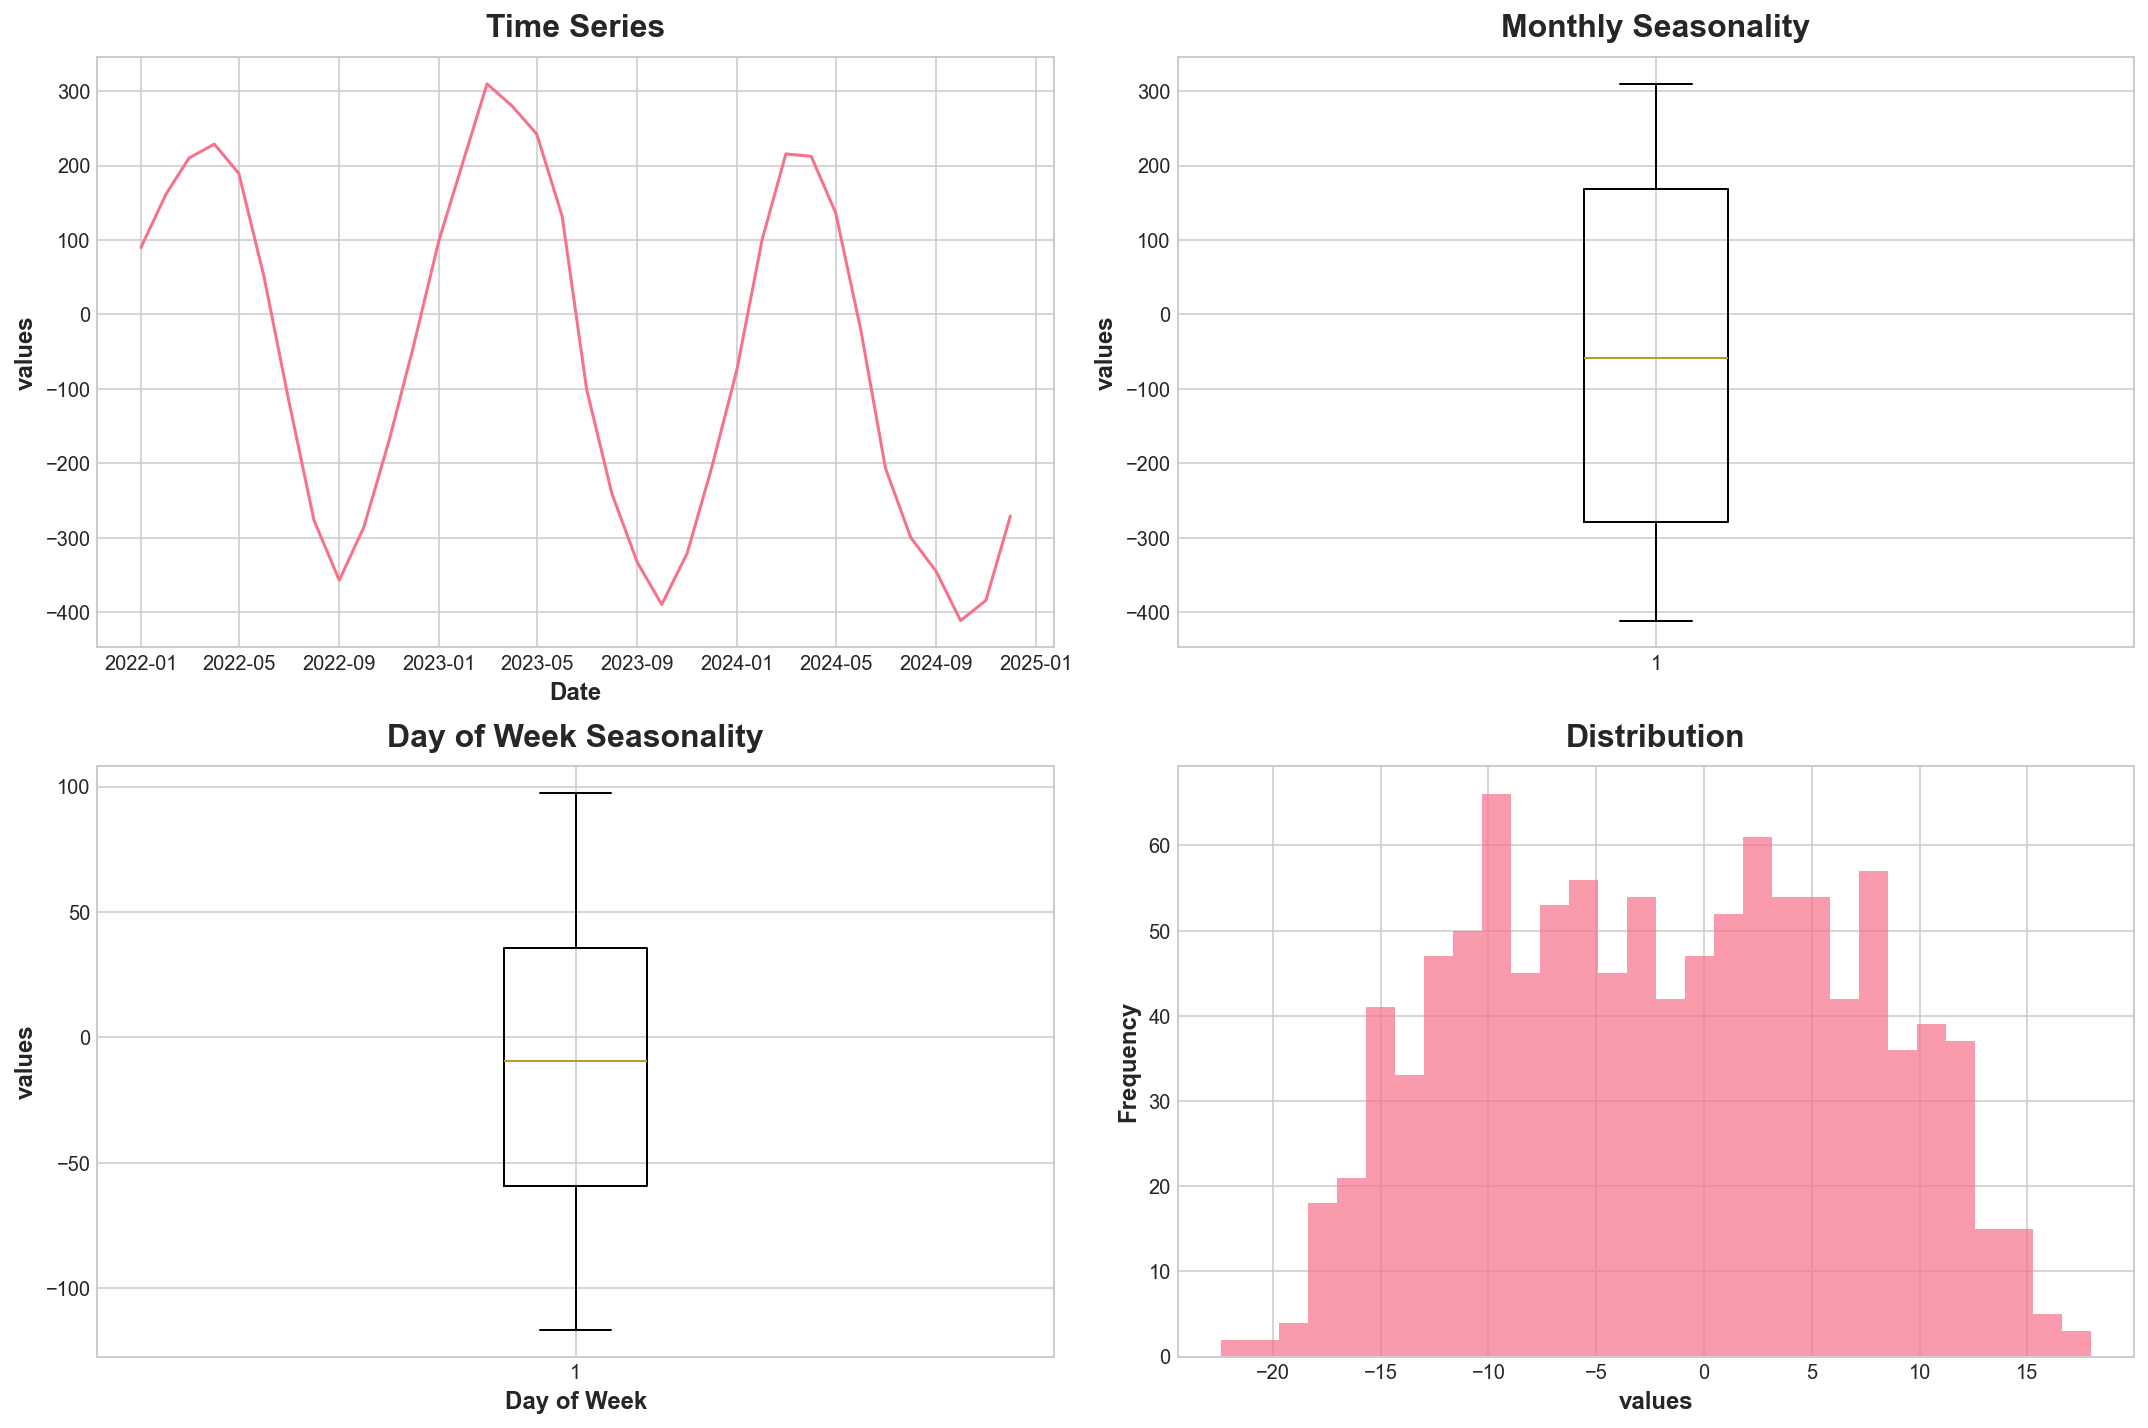

In [6]:
# look into the trend, monthly, daily outliers and the data distributions
time_series_ssd.visual_inspection()

### Auto-correlation (ACF & PACF)

- ACF: Properly check the stability or if there's any exponential decay, all lags are in the confidence interval -> White noise.

- PACF: Detect the order of auto-regressions, pay attention to the lag out of the confidence interval, those lags within the interval assuming there's no effect.


=== AUTOCORRELATION ANALYSIS ===


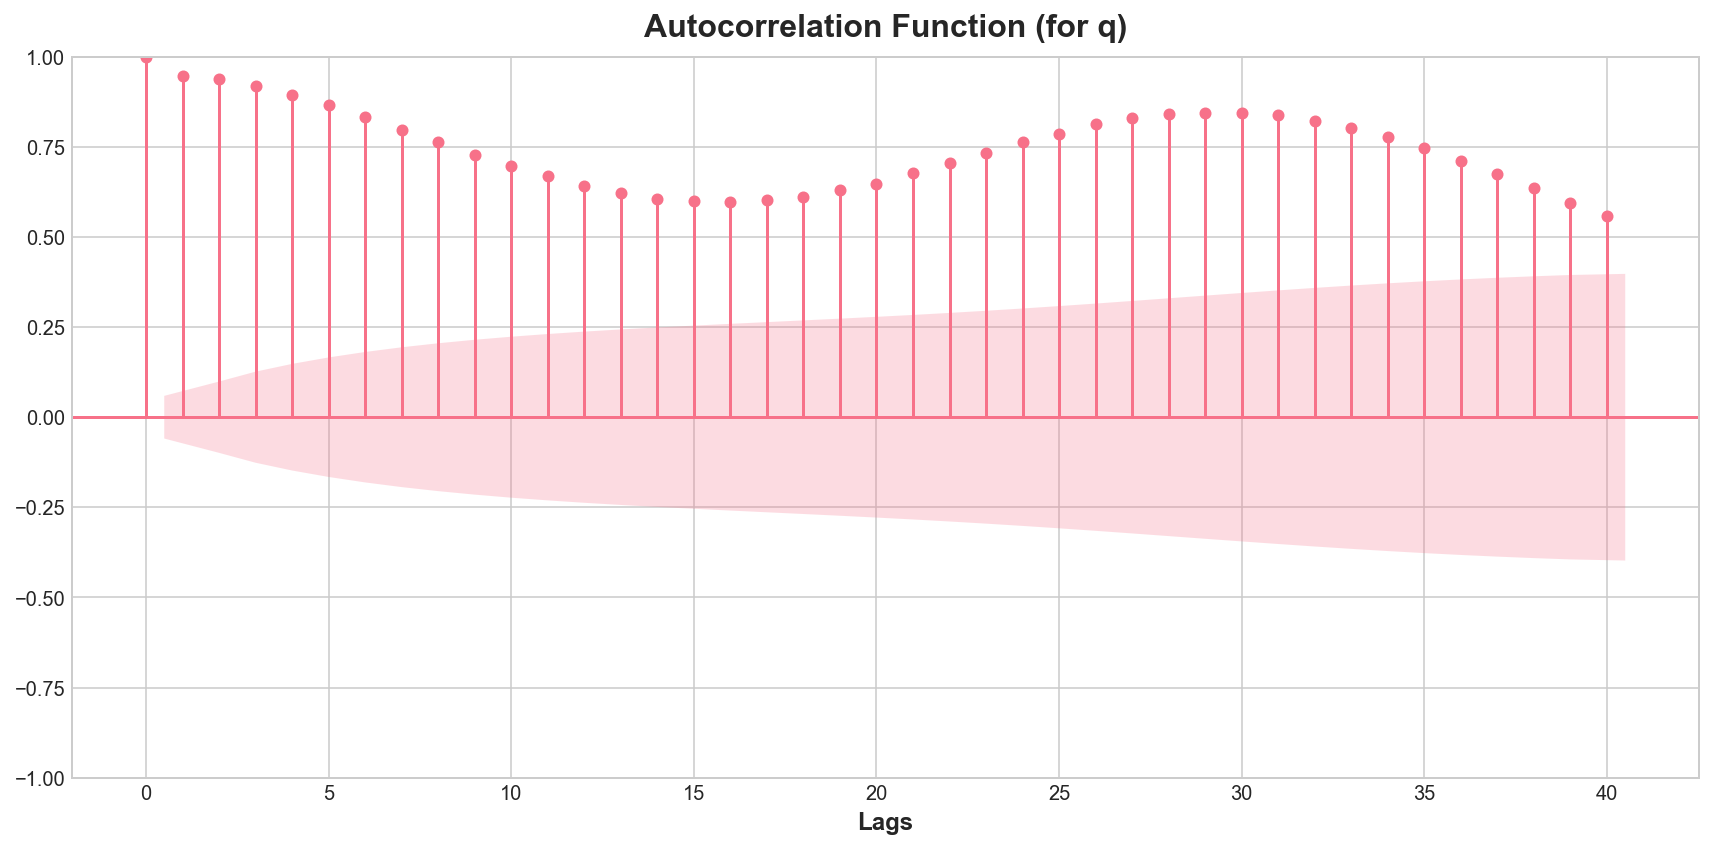

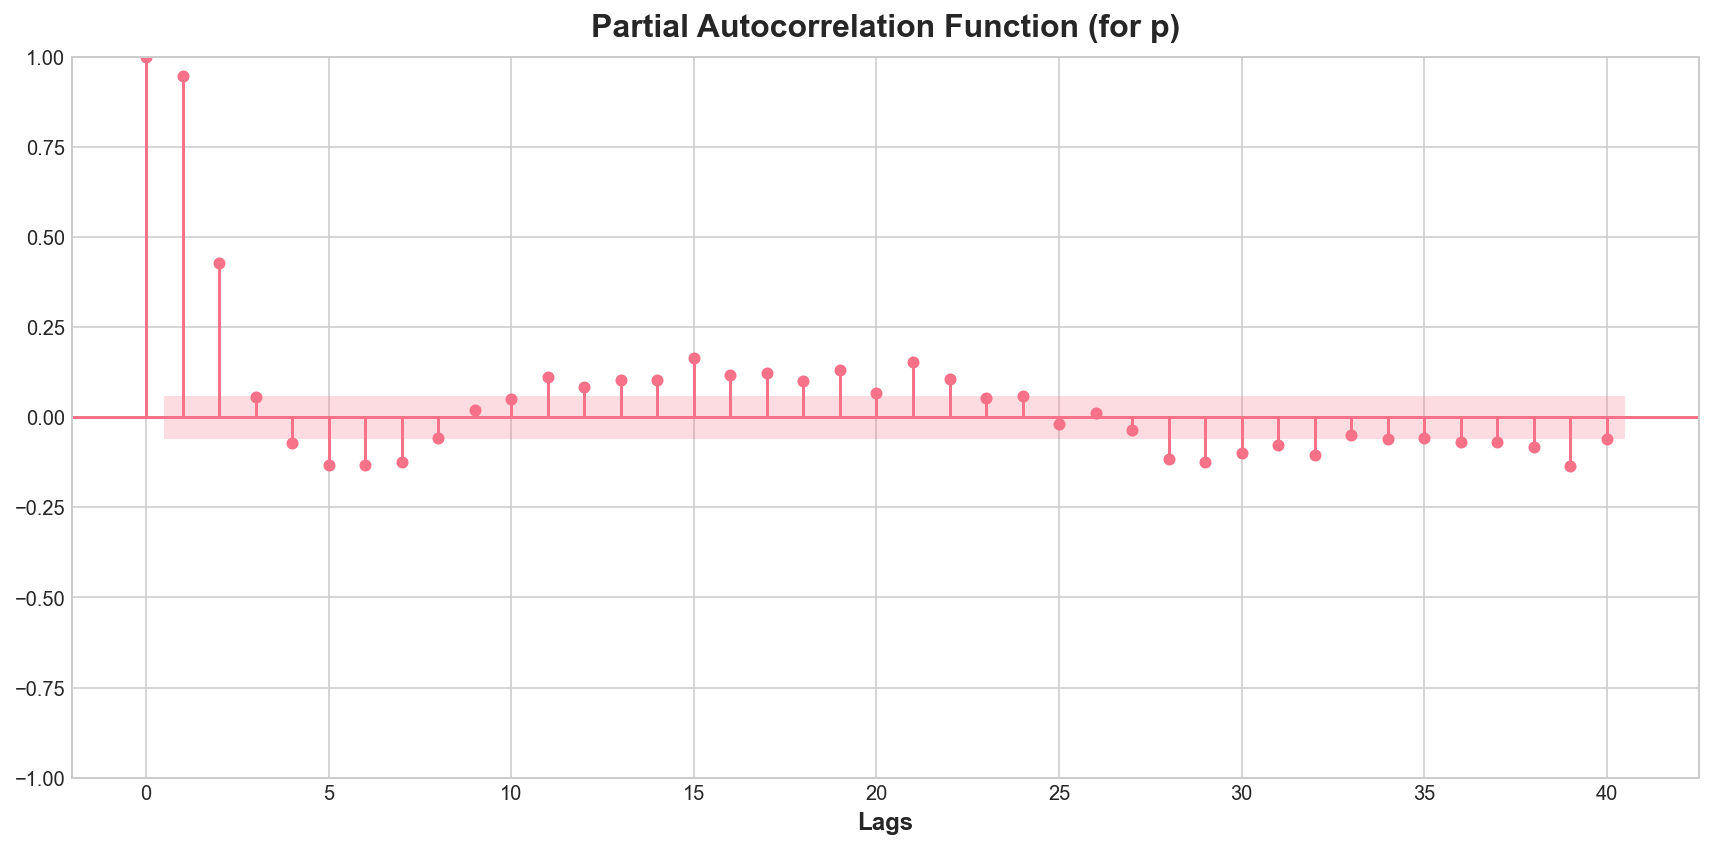


=== Overall correlation in daily ===
Lag 7 autocorrelation: 0.8003
Lag 30 autocorrelation: 0.8586
Lag 90 autocorrelation: 0.2949
Lag 180 autocorrelation: -0.5508
Lag 365 autocorrelation: 0.9039


In [7]:
# do the daily autocorrelation and see if previous days got an effect on the upcoming days
time_series_ssd.autocorrelation_analysis('daily')

### Seasonal decomposition

Default period will be 365 days to check on the trend, seasonal and the noise from the data.

I think it's not easy to get anything from the seasonal part. May be it's good to find some real sales data to check with the seanoality pattern for better observations.


=== SEASONAL DECOMPOSITION (Period: 365) ===


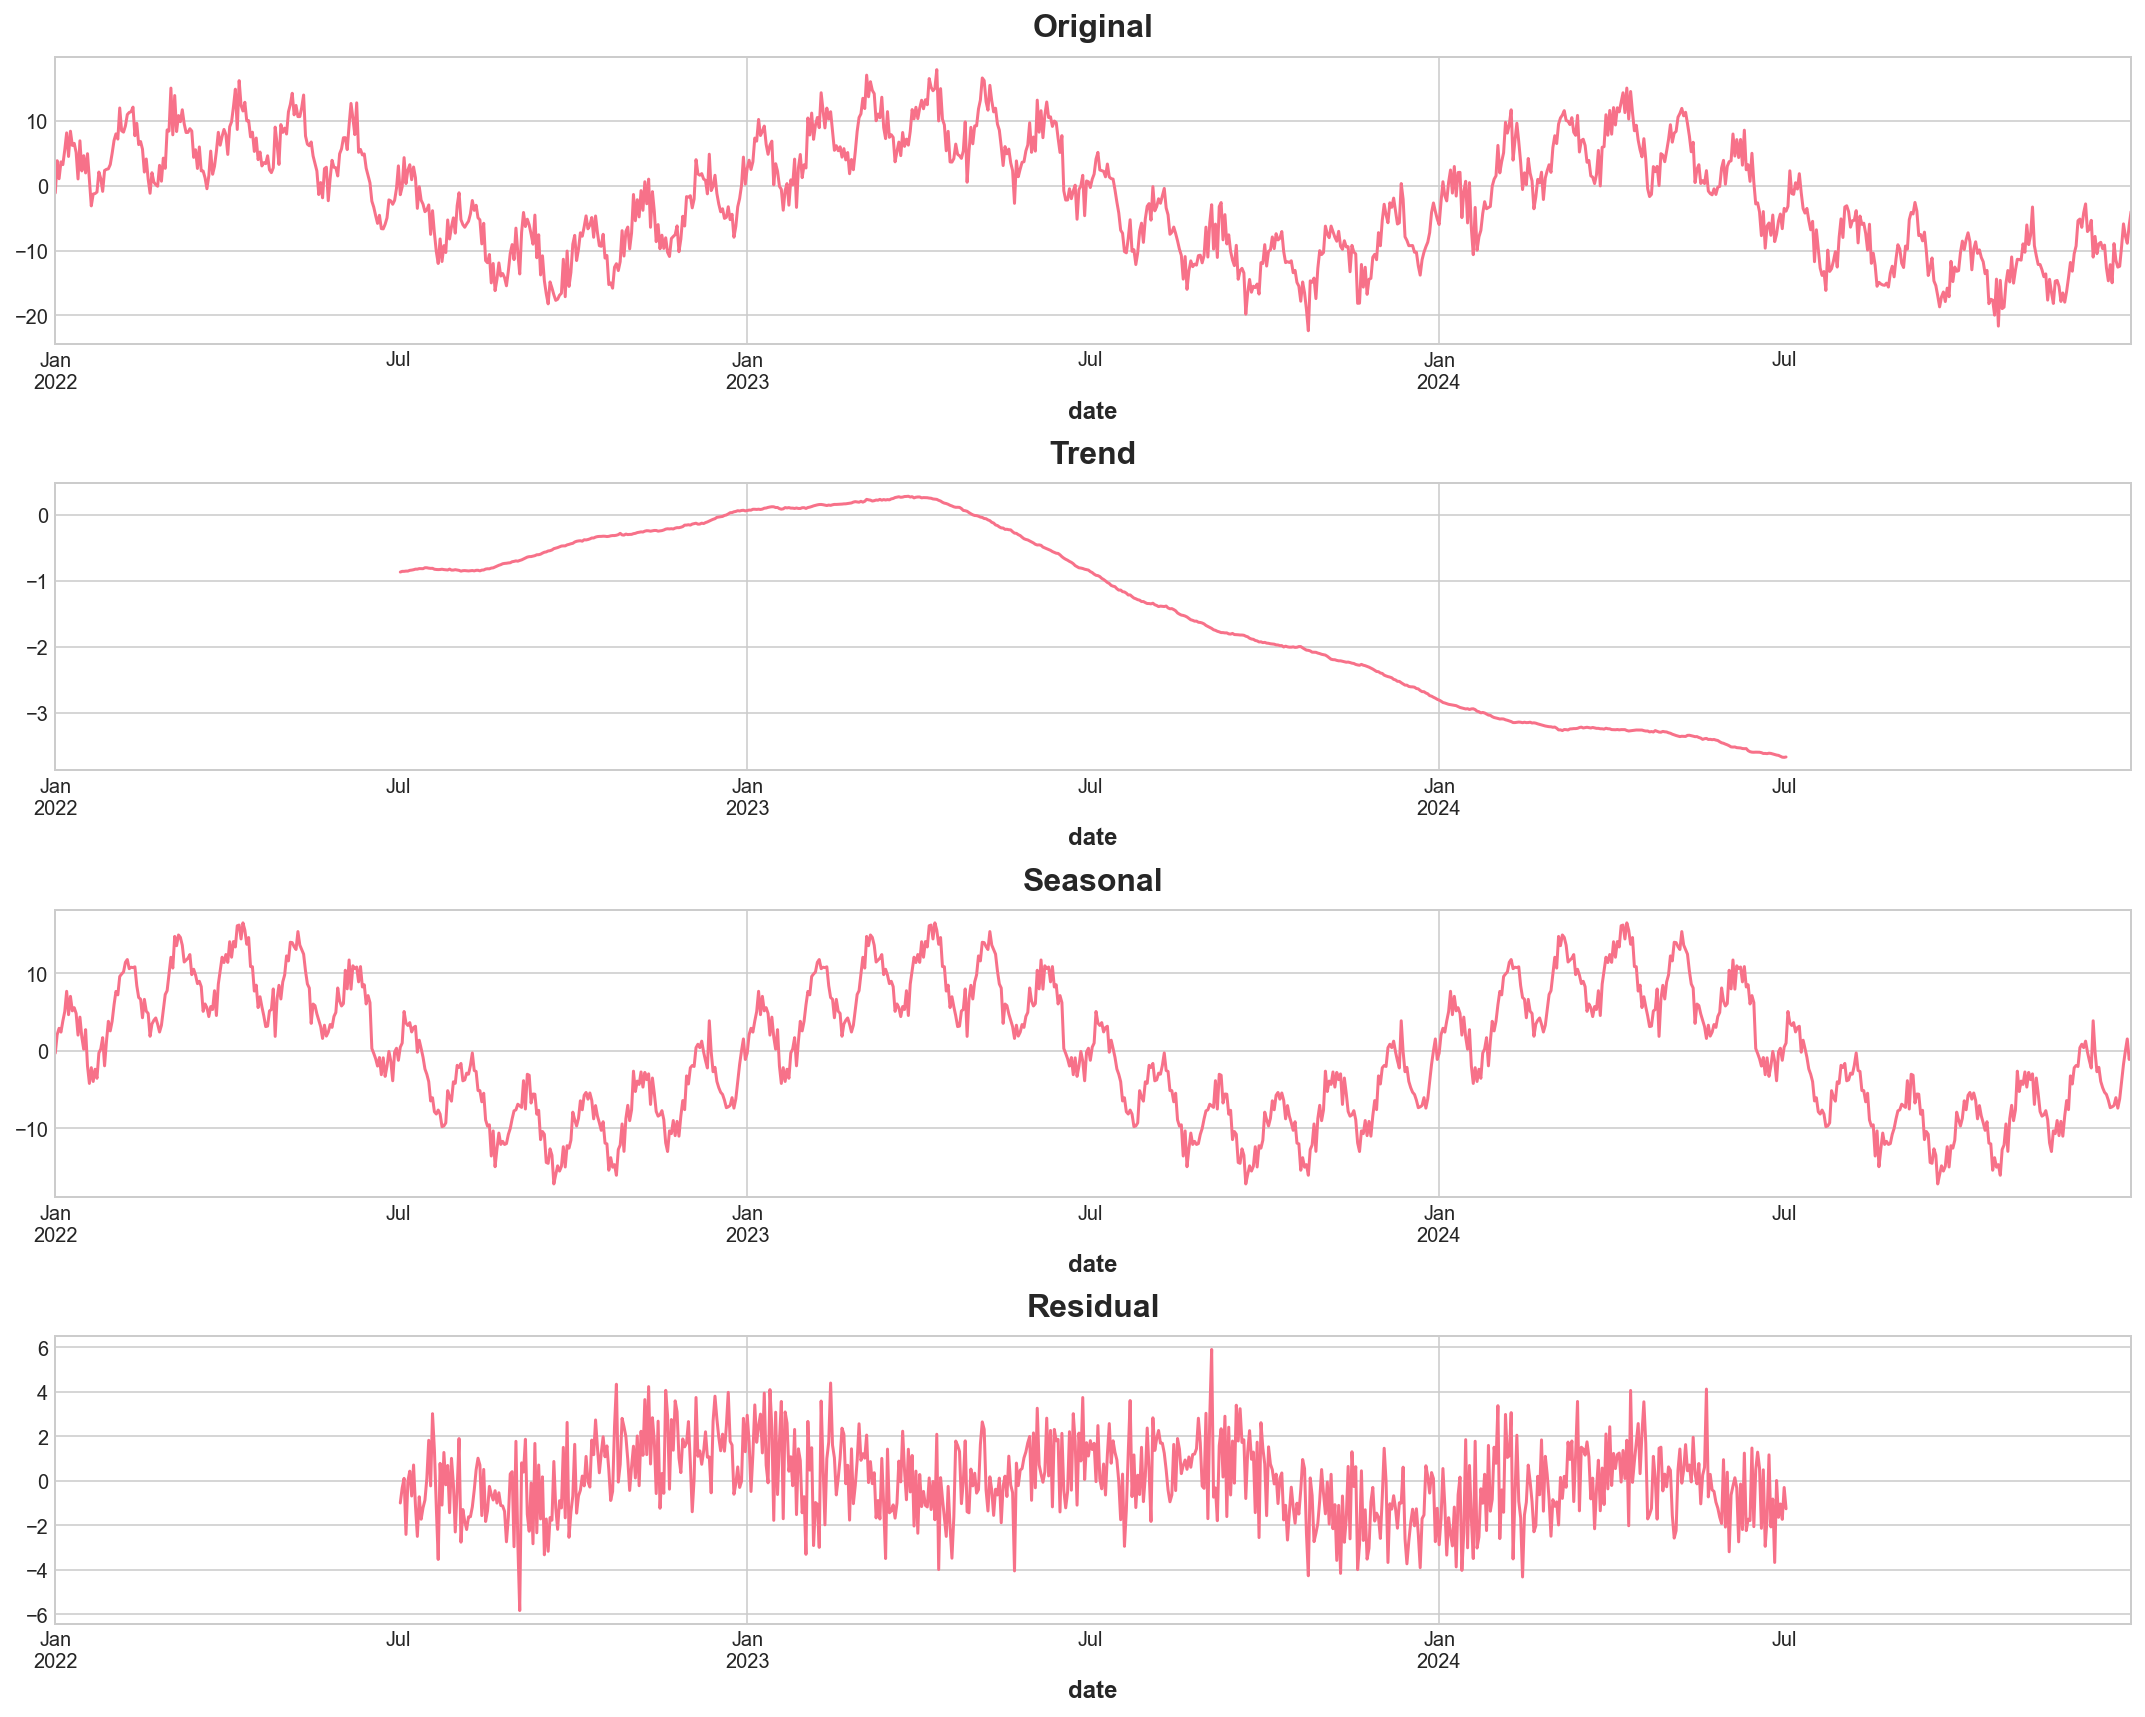

Seasonal Strength: 0.9585


In [8]:
# try to break down the data and see if there's any trend and season impact
# moving average & LOESS was used to get the trend
time_series_ssd.seasonal_decomposition()

## Day of week pattern

Based on the average to check if the some of the day of week may impact the target values. Therefore, it may help to plan say for the budget allocation and the weight across the week.

F-test is also applied to determine if there's any significant week of day effect.

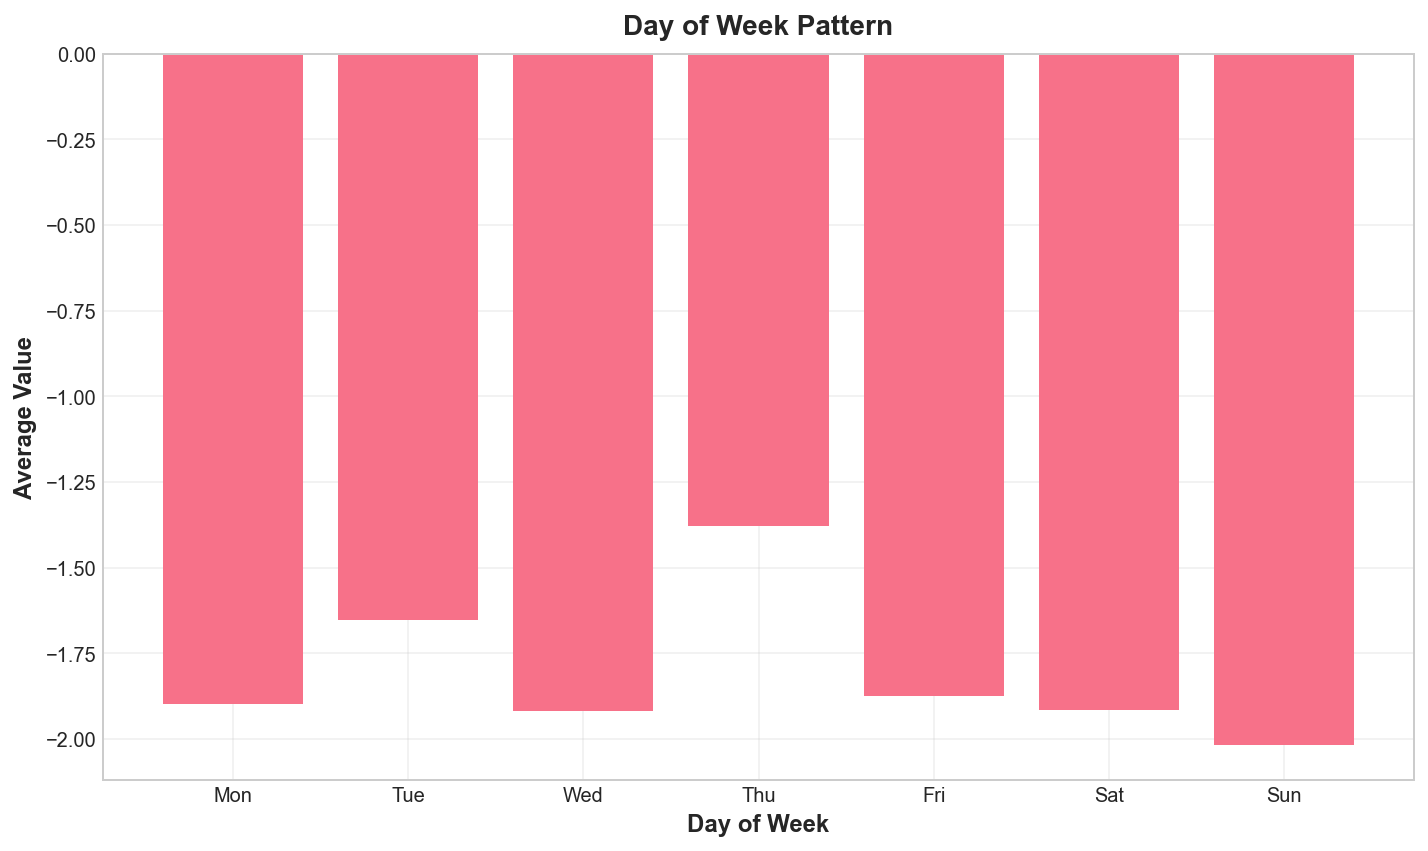


Day-of-Week Effect:
F-statistic: 0.0990, p-value: 0.9965
No significant day-of-week effect


In [9]:
time_series_ssd.day_of_week_pattern()

## Monthly Pattern

Similarly, this test checks whether any month carries significantly more weight compared to the yearly average. 

An F-test is also used to determine if a strong monthly effect is present.


Monthly Effect:
F-statistic: 253.9989, p-value: 0.0000
✓ Significant monthly effect detected!


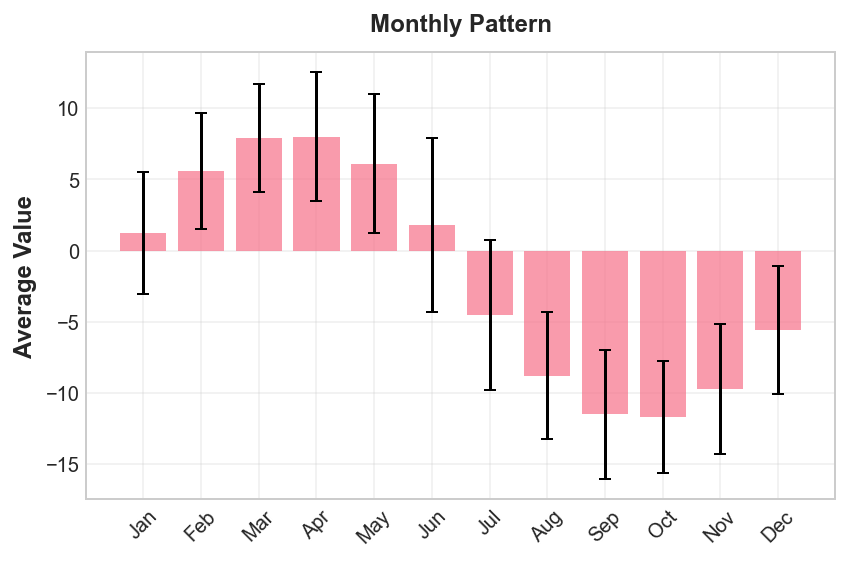

In [10]:
time_series_ssd.month_pattern()

## Week of year pattern

Similarly, this test checks whether any week out of the 52 weeks in a year carries significantly more weight compared to the yearly average.

Additionally, a one-way F-test (ANOVA) is used to determine whether a strong week-of-year effect is present.

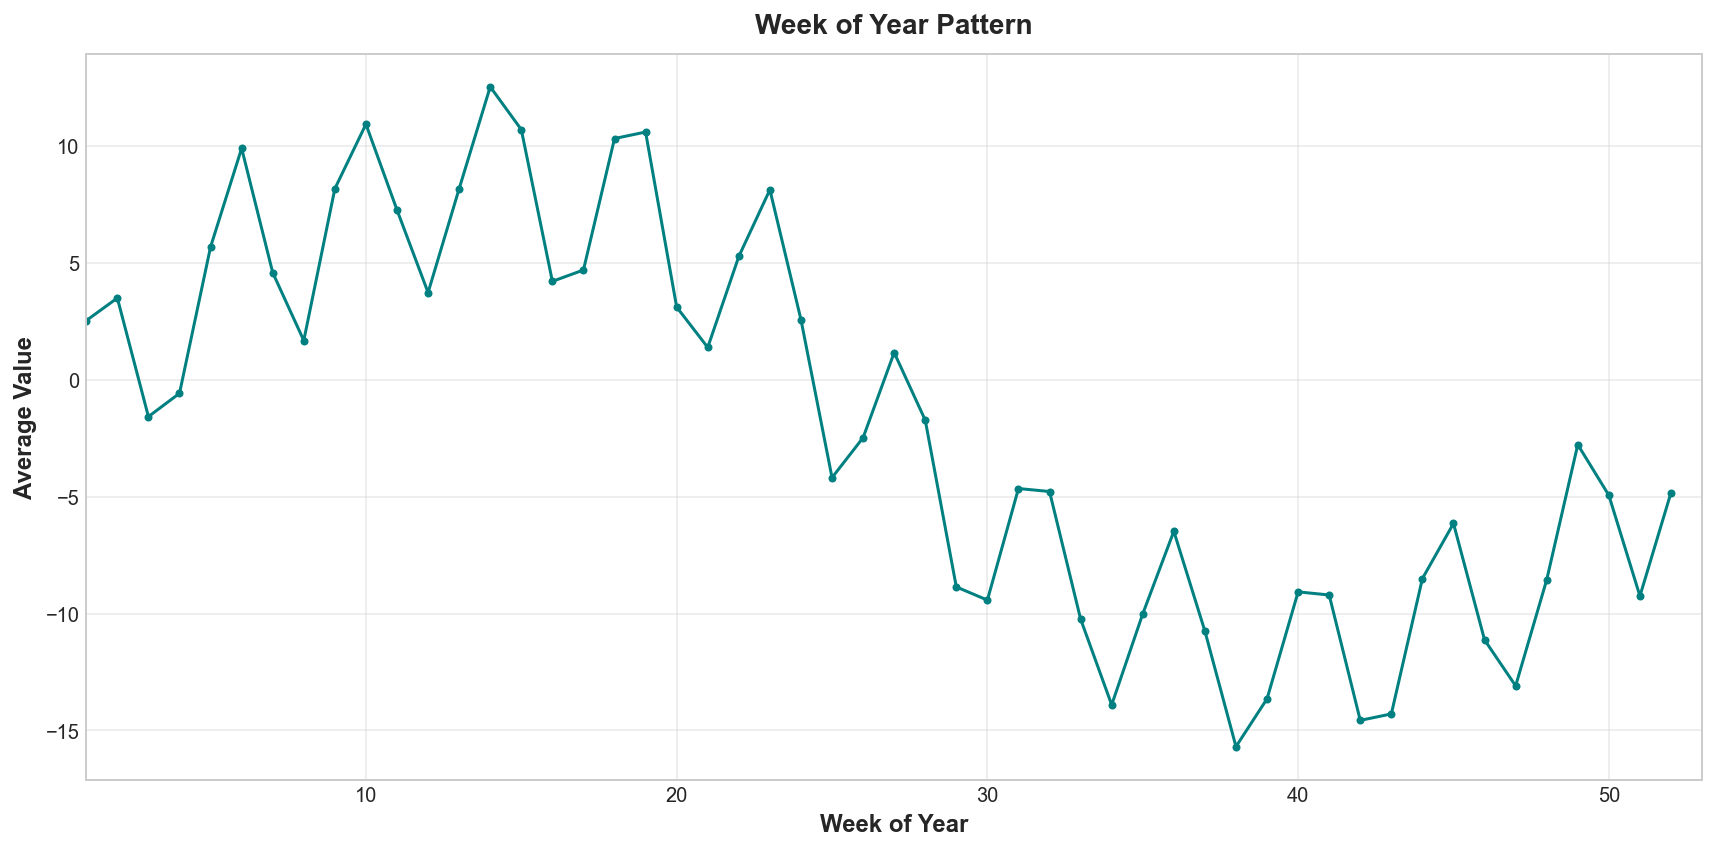


Week-of-Year Effect (ANOVA Test):
F-statistic: 129.8566, p-value: 0.0000
Significant week-of-year pattern detected!


In [11]:
time_series_ssd.week_of_year_pattern()

## Frequency domain analysis

This test is designed to check if any patterns can be found. In the example below, we can see a sharp peak at around 30 days. This indicates that a similar pattern was identified for approximately 30 days.


Frequency Analysis:
Dominant periods (days): [  30.44444444  137.          156.57142857  365.33333333 1096.        ]


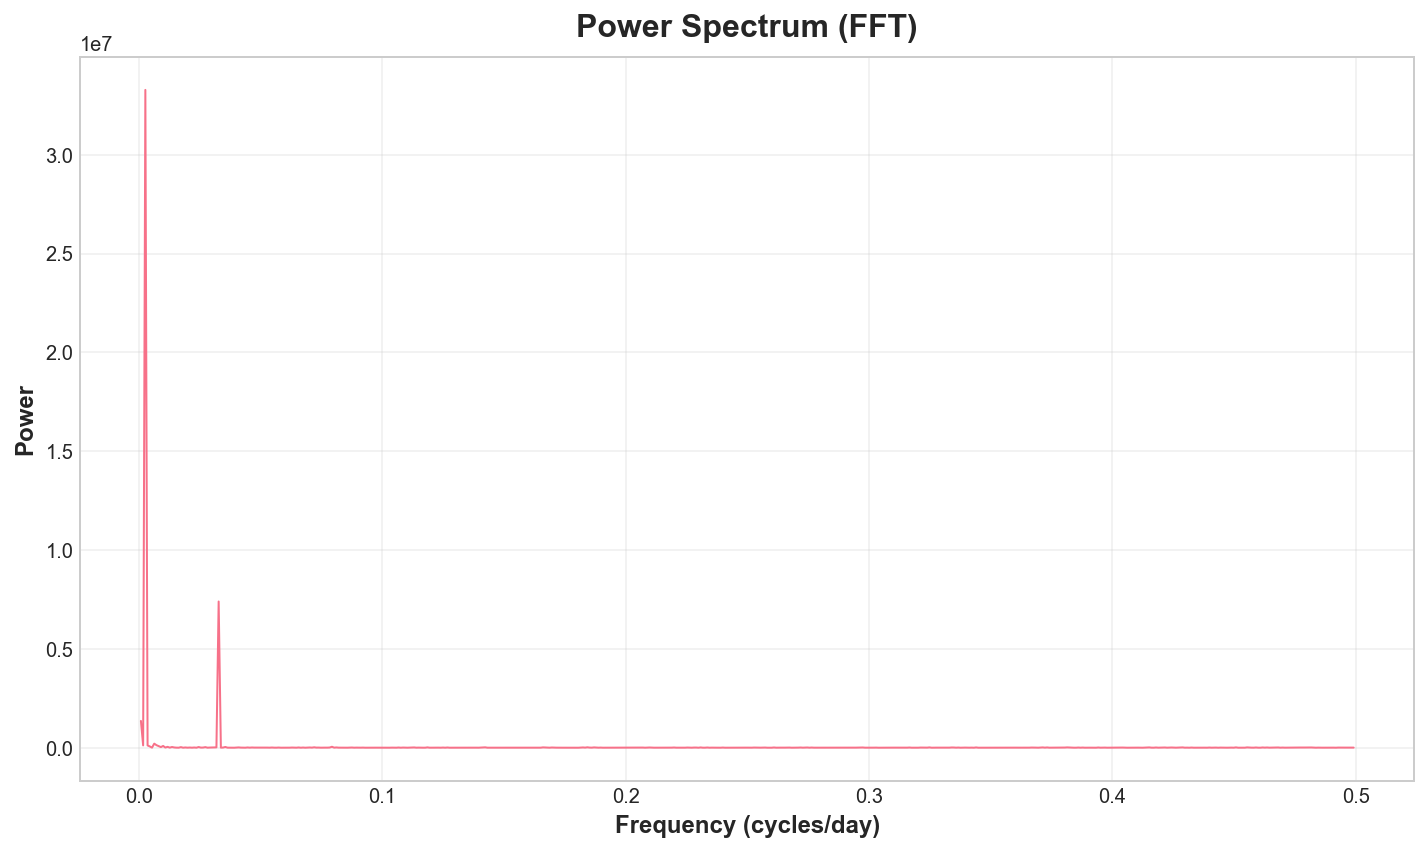

In [12]:
time_series_ssd.frequency_domain_analysis()

## ADF & Ljung-Box Test

### ADF test

The ADF test is used to check whether the time series is stationary. If the test rejects the null hypothesis, it means the series is stationary, making it suitable for use with the ARIMA model.

In [13]:
time_series_ssd.stationary_test_adf(time_series_ssd.ts)

ADF Test (Stationarity):
  ADF Statistic: -0.9014
  p-value: 0.7875
  Critical Values: {'1%': -3.436459052172655, '5%': -2.864237372528562, '10%': -2.568206176974609}
  Result: Series is non-stationary


### Ljung-Box Test

The Ljung-Box test is used to assess whether the residuals from the model are random. This test should be applied after building the ARIMA model. If your model is good, the Ljung-Box test should not be rejected, indicating that the residuals are randomly distributed and that all non-random information (such as trend, seasonality, and autocorrelation) has been successfully explained by the model.

In [14]:
time_series_ssd.autocorrelation_Ljung_box(time_series_ssd.ts)

Ljung-Box test failed


## Trend analysis on time series based on the moving average trend

Using the trend identified by a moving average, we will generate deterministic polynomial features. These features will then be used to fit the data and produce a simple forecast.


STATISTICAL TESTS


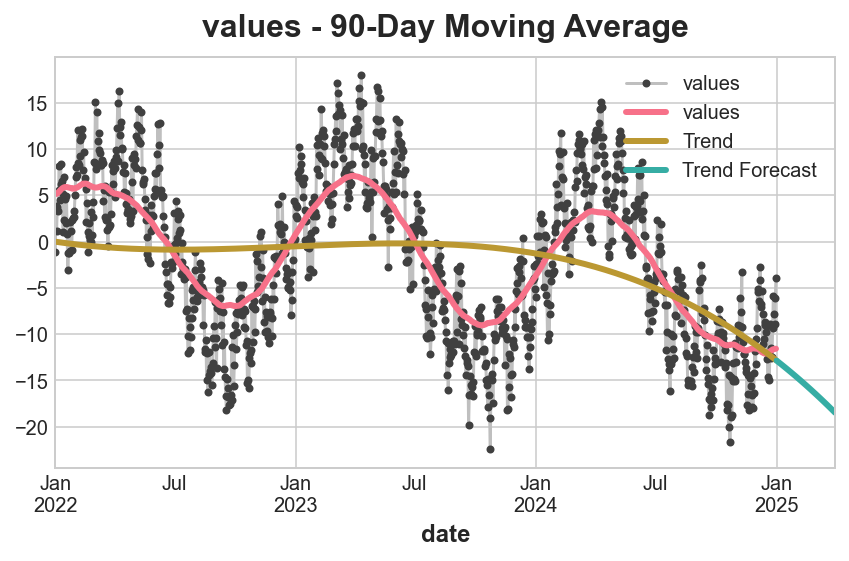

In [15]:
time_series_ssd.trend_analysis(180)

In [16]:
# TODO: Time series feature Time Step & Lag_1